In [31]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy import stats
from scipy.spatial.distance import pdist, cdist
from scipy.spatial import cKDTree
import seaborn as sns
import pandas as pd
import umap
from sklearn.manifold import MDS
from scipy.spatial.distance import squareform, pdist

from tqdm import tqdm
import os

from src.models import ContextSpaceNet, OldSpaceNet, RecurrentSpaceNet, Decoder, End2EndSpaceNet
from src.utils import ratemap_collage, SimpleDatasetMaker

plt.rcdefaults()
plt.style.use("figures/project_style.mplstyle")
%matplotlib inline

Just curious how the loss function looks like...

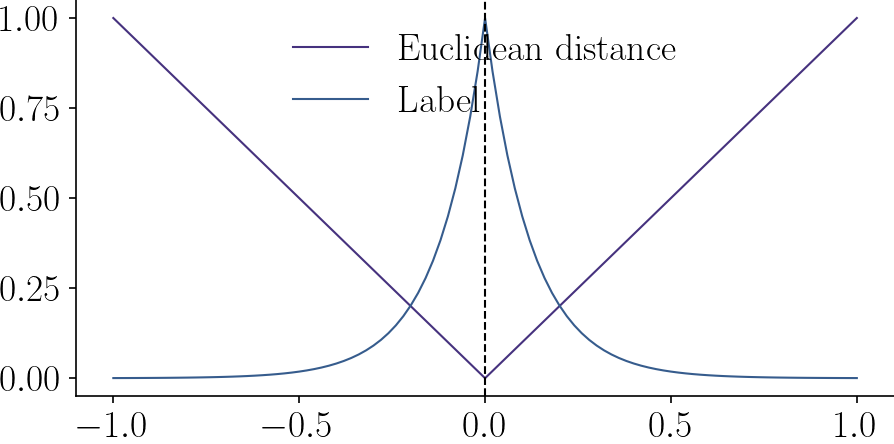

In [25]:
scale = 0.25
x0 = 0
x = np.linspace(-1, 1, 101)

# Euclidean distance of x0 to x
y = np.sqrt((x - x0)**2)

plt.figure(figsize=(6, 3))
plt.plot(x, y, label="Euclidean distance")

y = np.exp(-0.5 / scale ** 2 * y)

plt.plot(x, y, label="Label")

plt.axvline(0, color='black', ls='--')
plt.legend()

So what our loss function basically does is that it forces you to learn representations that preserve the euclidean distances between the input data points. However, it does so in a non-linear way, by using a Gaussian kernel. This is a common trick in manifold learning, where you want to learn a low-dimensional representation of high-dimensional data that preserves the structure of the data. In contrast to just using the euclidean distances, the Gaussian kernel does not care too much about exact distances the further away the points are. We can imagine that for x1 > 0.5, it is enough to come up with a very dissimilar representation to x0 in order to drive the loss to zero. This is because the Gaussian kernel will be very close to zero for x1 > 0.5. On the other hand, the closer x1 moves to x0, the more important it is to actually preserve the distance between x0 and x1 because the loss will increase if we don't.

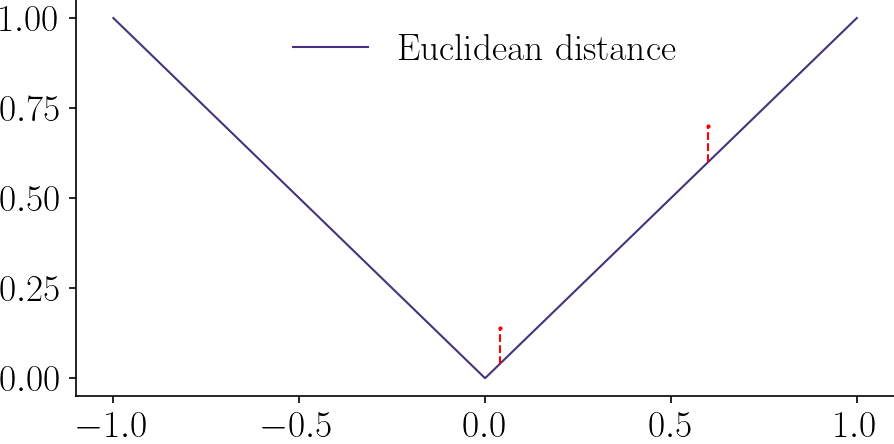

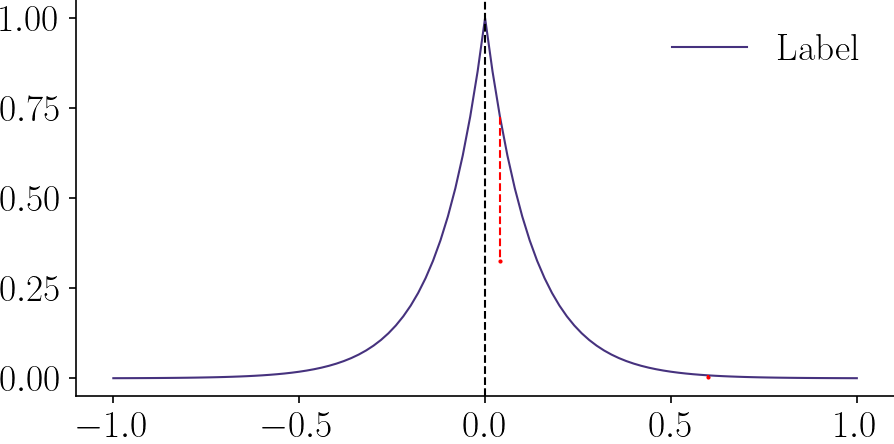

In [26]:
scale = 0.25
x0 = 0
x = np.linspace(-1, 1, 101)

# Euclidean distance of x0 to x
y = np.sqrt((x - x0)**2)

y_learned_near = y[52] + 0.1
y_learned_far = y[80] + 0.1

plt.figure(figsize=(6, 3))
plt.plot(x, y, label="Euclidean distance")
plt.scatter(x[52], y_learned_near, color='red')
plt.scatter(x[80], y_learned_far, color='red')

# Plot vertical lines indicating the error
plt.plot([x[52], x[52]], [y[52], y_learned_near], color='red', ls='--')
plt.plot([x[80], x[80]], [y[80], y_learned_far], color='red', ls='--')

plt.legend()
plt.show()

y_learned_near = np.exp(-0.5 / scale ** 2 * y_learned_near)
y_learned_far = np.exp(-0.5 / scale ** 2 * y_learned_far)

y = np.exp(-0.5 / scale ** 2 * y)

plt.figure(figsize=(6, 3))
plt.plot(x, y, label="Label")

error_near = (y_learned_near - y[52]) ** 2
error_far = (y_learned_far - y[80]) ** 2

plt.scatter(x[52], y_learned_near, color='red')
plt.scatter(x[80], y_learned_far, color='red')

# Plot vertical lines indicating the error
plt.plot([x[52], x[52]], [y[52], y_learned_near], color='red', ls='--')
plt.plot([x[80], x[80]], [y[80], y_learned_far], color='red', ls='--')

plt.axvline(0, color='black', ls='--')
plt.legend()



One problem with this representation is that it ecnourages you to learn very dissimilar representations the further away you go. One strategy to achieve that would be to increase the magnitude in some dimensions in order to increase the euclidean distance. However, as we have the energy constraint as an additional loss term, we get a tradeoff between increasing the distance but keeping the magnitudes low. This results in some units to switch off when others are on. This can best be seen when we imagine  

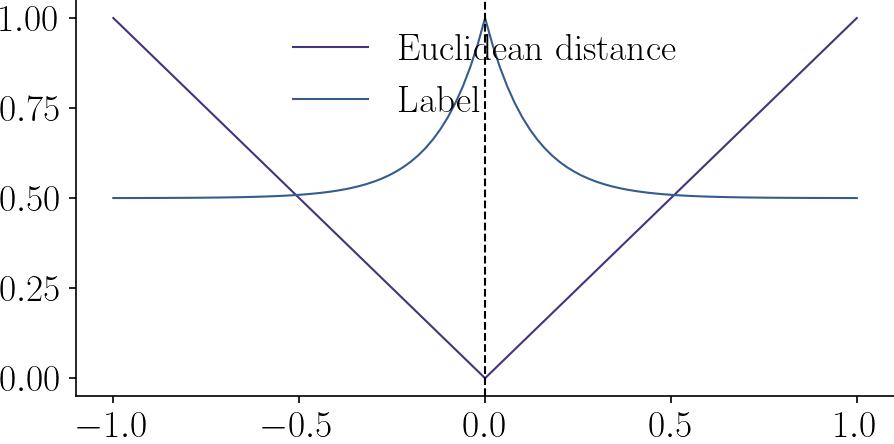

In [27]:
scale = 0.25
beta = 0.5
x0 = 0
x = np.linspace(-1, 1, 101)

# Euclidean distance of x0 to x
y = np.sqrt((x - x0)**2)

plt.figure(figsize=(6, 3))
plt.plot(x, y, label="Euclidean distance")

y = np.exp(-0.5 / scale ** 2 * y)
y = y * (1 - beta) + beta

plt.plot(x, y, label="Label")

plt.axvline(0, color='black', ls='--')
plt.legend()

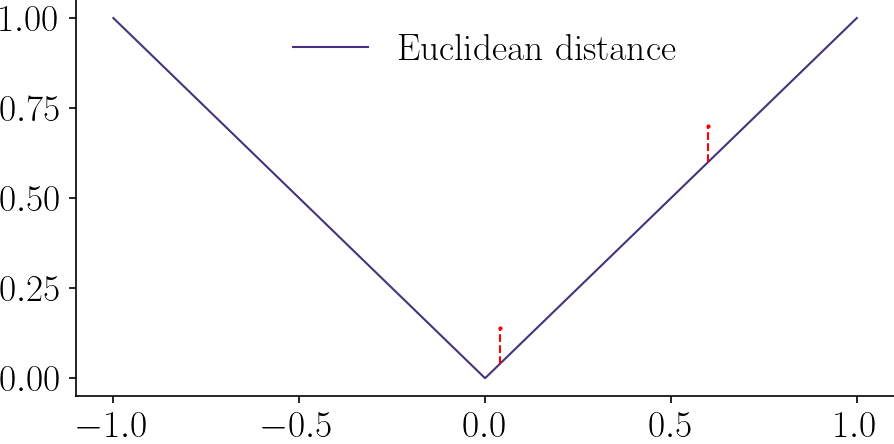

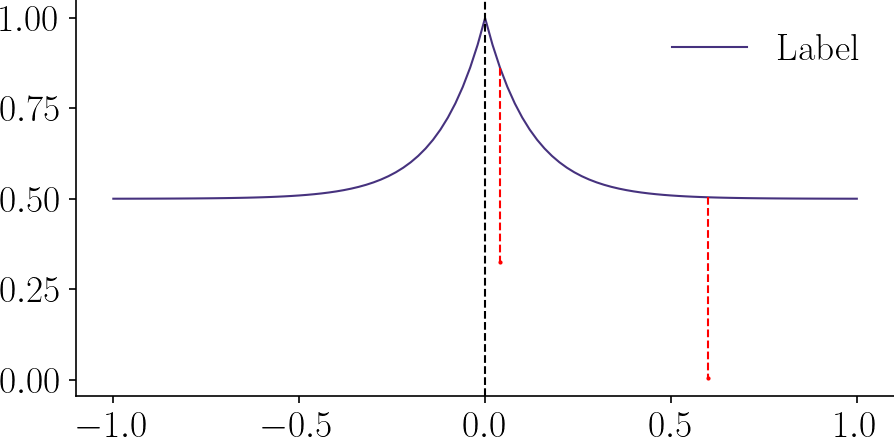

In [38]:
scale = 0.25
x0 = 0
x = np.linspace(-1, 1, 101)

# Euclidean distance of x0 to x
y = np.sqrt((x - x0)**2)

y_learned_near = y[52] + 0.1
y_learned_far = y[80] + 0.1

plt.figure(figsize=(6, 3))
plt.plot(x, y, label="Euclidean distance")
plt.scatter(x[52], y_learned_near, color='red')
plt.scatter(x[80], y_learned_far, color='red')

# Plot vertical lines indicating the error
plt.plot([x[52], x[52]], [y[52], y_learned_near], color='red', ls='--')
plt.plot([x[80], x[80]], [y[80], y_learned_far], color='red', ls='--')

plt.legend()
plt.show()

y_learned_near = np.exp(-0.5 / scale ** 2 * y_learned_near)
y_learned_far = np.exp(-0.5 / scale ** 2 * y_learned_far)

# y_learned_near = y_learned_near * (1 - beta) + beta
# y_learned_far = y_learned_far * (1 - beta) + beta

y = np.exp(-0.5 / scale ** 2 * y)
y = y * (1 - beta) + beta

plt.figure(figsize=(6, 3))
plt.plot(x, y, label="Label")

error_near = (y_learned_near - y[52]) ** 2
error_far = (y_learned_far - y[80]) ** 2

plt.scatter(x[52], y_learned_near, color='red')
plt.scatter(x[80], y_learned_far, color='red')

# Plot vertical lines indicating the error
plt.plot([x[52], x[52]], [y[52], y_learned_near], color='red', ls='--')
plt.plot([x[80], x[80]], [y[80], y_learned_far], color='red', ls='--')

plt.axvline(0, color='black', ls='--')
plt.legend()
plt.show()

Let's evaluate even more points

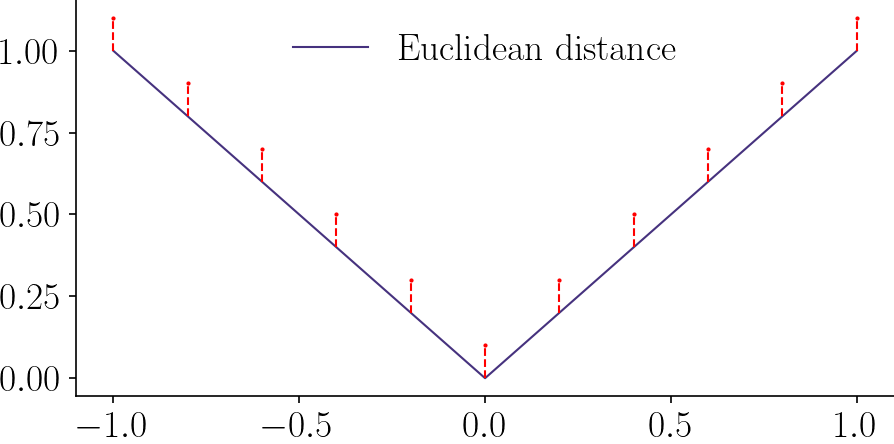

ValueError: operands could not be broadcast together with shapes (101,) (11,) 

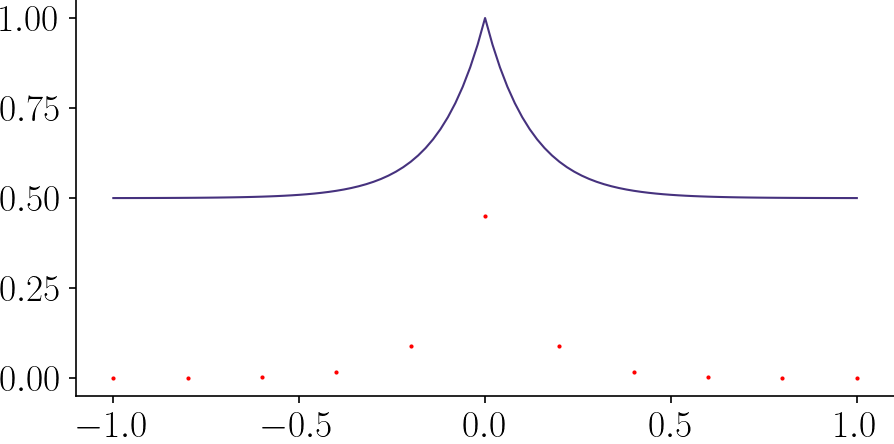

In [52]:
scale = 0.25
x0 = 0

eval_points = np.arange(0, 101, 10)

x = np.linspace(-1, 1, 101)

# Euclidean distance of x0 to x
y = np.sqrt((x - x0)**2)

y_learned = y + 0.1

plt.figure(figsize=(6, 3))
plt.plot(x, y, label="Euclidean distance")

plt.scatter(x[eval_points], y_learned[eval_points], color='red')

# Plot vertical lines indicating the error
for i in eval_points:
    plt.plot([x[i], x[i]], [y[i], y_learned[i]], color='red', ls='--')

plt.legend()
plt.show()

y_learned = np.exp(-0.5 / scale ** 2 * y_learned)

y = np.exp(-0.5 / scale ** 2 * y)
y = y * (1 - beta) + beta

plt.figure(figsize=(6, 3))
plt.plot(x, y, label="Label")


plt.scatter(x[eval_points], y_learned[eval_points], color='red')
 
error = (y_learned - y[eval_points]) ** 2
# # Plot vertical lines indicating the error
# for i in eval_points:
#     plt.plot([x[i], x[i]], [y[i], y_learned[i]], color='red', ls='--')
# 
plt.axvline(0, color='black', ls='--')
plt.ylim(0, 1)
plt.legend()
plt.show()

In [44]:
y_learned

array([1.50733075e-04, 1.76886902e-04, 2.07578703e-04, 2.43595864e-04,
       2.85862395e-04, 3.35462628e-04, 3.93669041e-04, 4.61974899e-04,
       5.42132566e-04, 6.36198460e-04, 7.46585808e-04, 8.76126562e-04,
       1.02814405e-03, 1.20653821e-03, 1.41588571e-03, 1.66155727e-03,
       1.94985552e-03, 2.28817665e-03, 2.68520018e-03, 3.15111160e-03,
       3.69786372e-03, 4.33948327e-03, 5.09243079e-03, 5.97602290e-03,
       7.01292783e-03, 8.22974705e-03, 9.65769763e-03, 1.13334132e-02,
       1.32998835e-02, 1.56075579e-02, 1.83156389e-02, 2.14936013e-02,
       2.52229748e-02, 2.95994352e-02, 3.47352589e-02, 4.07622040e-02,
       4.78348895e-02, 5.61347628e-02, 6.58747544e-02, 7.73047404e-02,
       9.07179533e-02, 1.06458504e-01, 1.24930212e-01, 1.46606962e-01,
       1.72044864e-01, 2.01896518e-01, 2.36927759e-01, 2.78037300e-01,
       3.26279795e-01, 3.82892886e-01, 4.49328964e-01, 3.82892886e-01,
       3.26279795e-01, 2.78037300e-01, 2.36927759e-01, 2.01896518e-01,
      

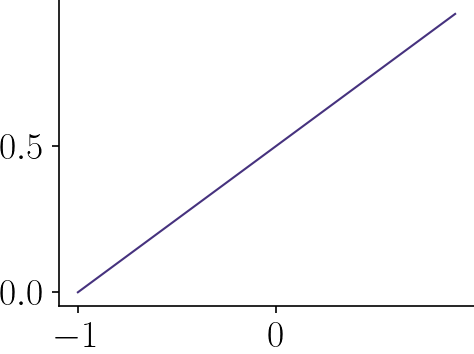

In [29]:
x = np.arange(-1, 1, 0.1)

y = x * (1 - 0.5) + 0.5

plt.plot(x, y)